# Initial setup

In [1]:
import os
import numpy as np
import seaborn as sns
from scipy import stats
from getpass import getpass
from dotenv import load_dotenv
import matplotlib.pyplot as plt

import wandb
import torch
import pytorch_lightning as pl
from sklearn.model_selection import KFold

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from models import CNNClassifier, MatrixDataset, get_feature_maps

# Load and inspect data

In [4]:
# Load data
data_path = "../data/"
all_C = np.load(data_path + 'all_C.npy') # 1329 input matrices of size 30x30
nMF_label = np.load(data_path + 'nMF_label.npy') # 1329 output labels (0 or 1)

class_0_C = all_C[nMF_label == 0] # input matrices of size 30x30 with nMF label 0
class_1_C = all_C[nMF_label == 1] # input matrices of size 30x30 with nMF label 1

# print some stats
print(f"Number of input matrices with nMF label 0: {class_0_C.shape[0]}")
print(f"Number of input matrices with nMF label 1: {class_1_C.shape[0]}")

Number of input matrices with nMF label 0: 574
Number of input matrices with nMF label 1: 755


In [5]:
# Check the normality of the data
non_normal_indices = []

# Test each matrix individually
for i in range(len(all_C)):
    # Flatten current matrix
    matrix_flat = all_C[i].flatten()
    
    # Perform normality test
    _, p_value = stats.normaltest(matrix_flat)
    
    # If p-value <= 0.05, the distribution is not normal
    if p_value <= 0.05:
        non_normal_indices.append(i)

# Print results
if len(non_normal_indices) == 0:
    print("Normality check passed: All matrices are normally distributed")
else:
    print(f"Normality check failed: {len(non_normal_indices)} out of {len(all_C)} matrices are not normally distributed")

Normality check failed: 1328 out of 1329 matrices are not normally distributed


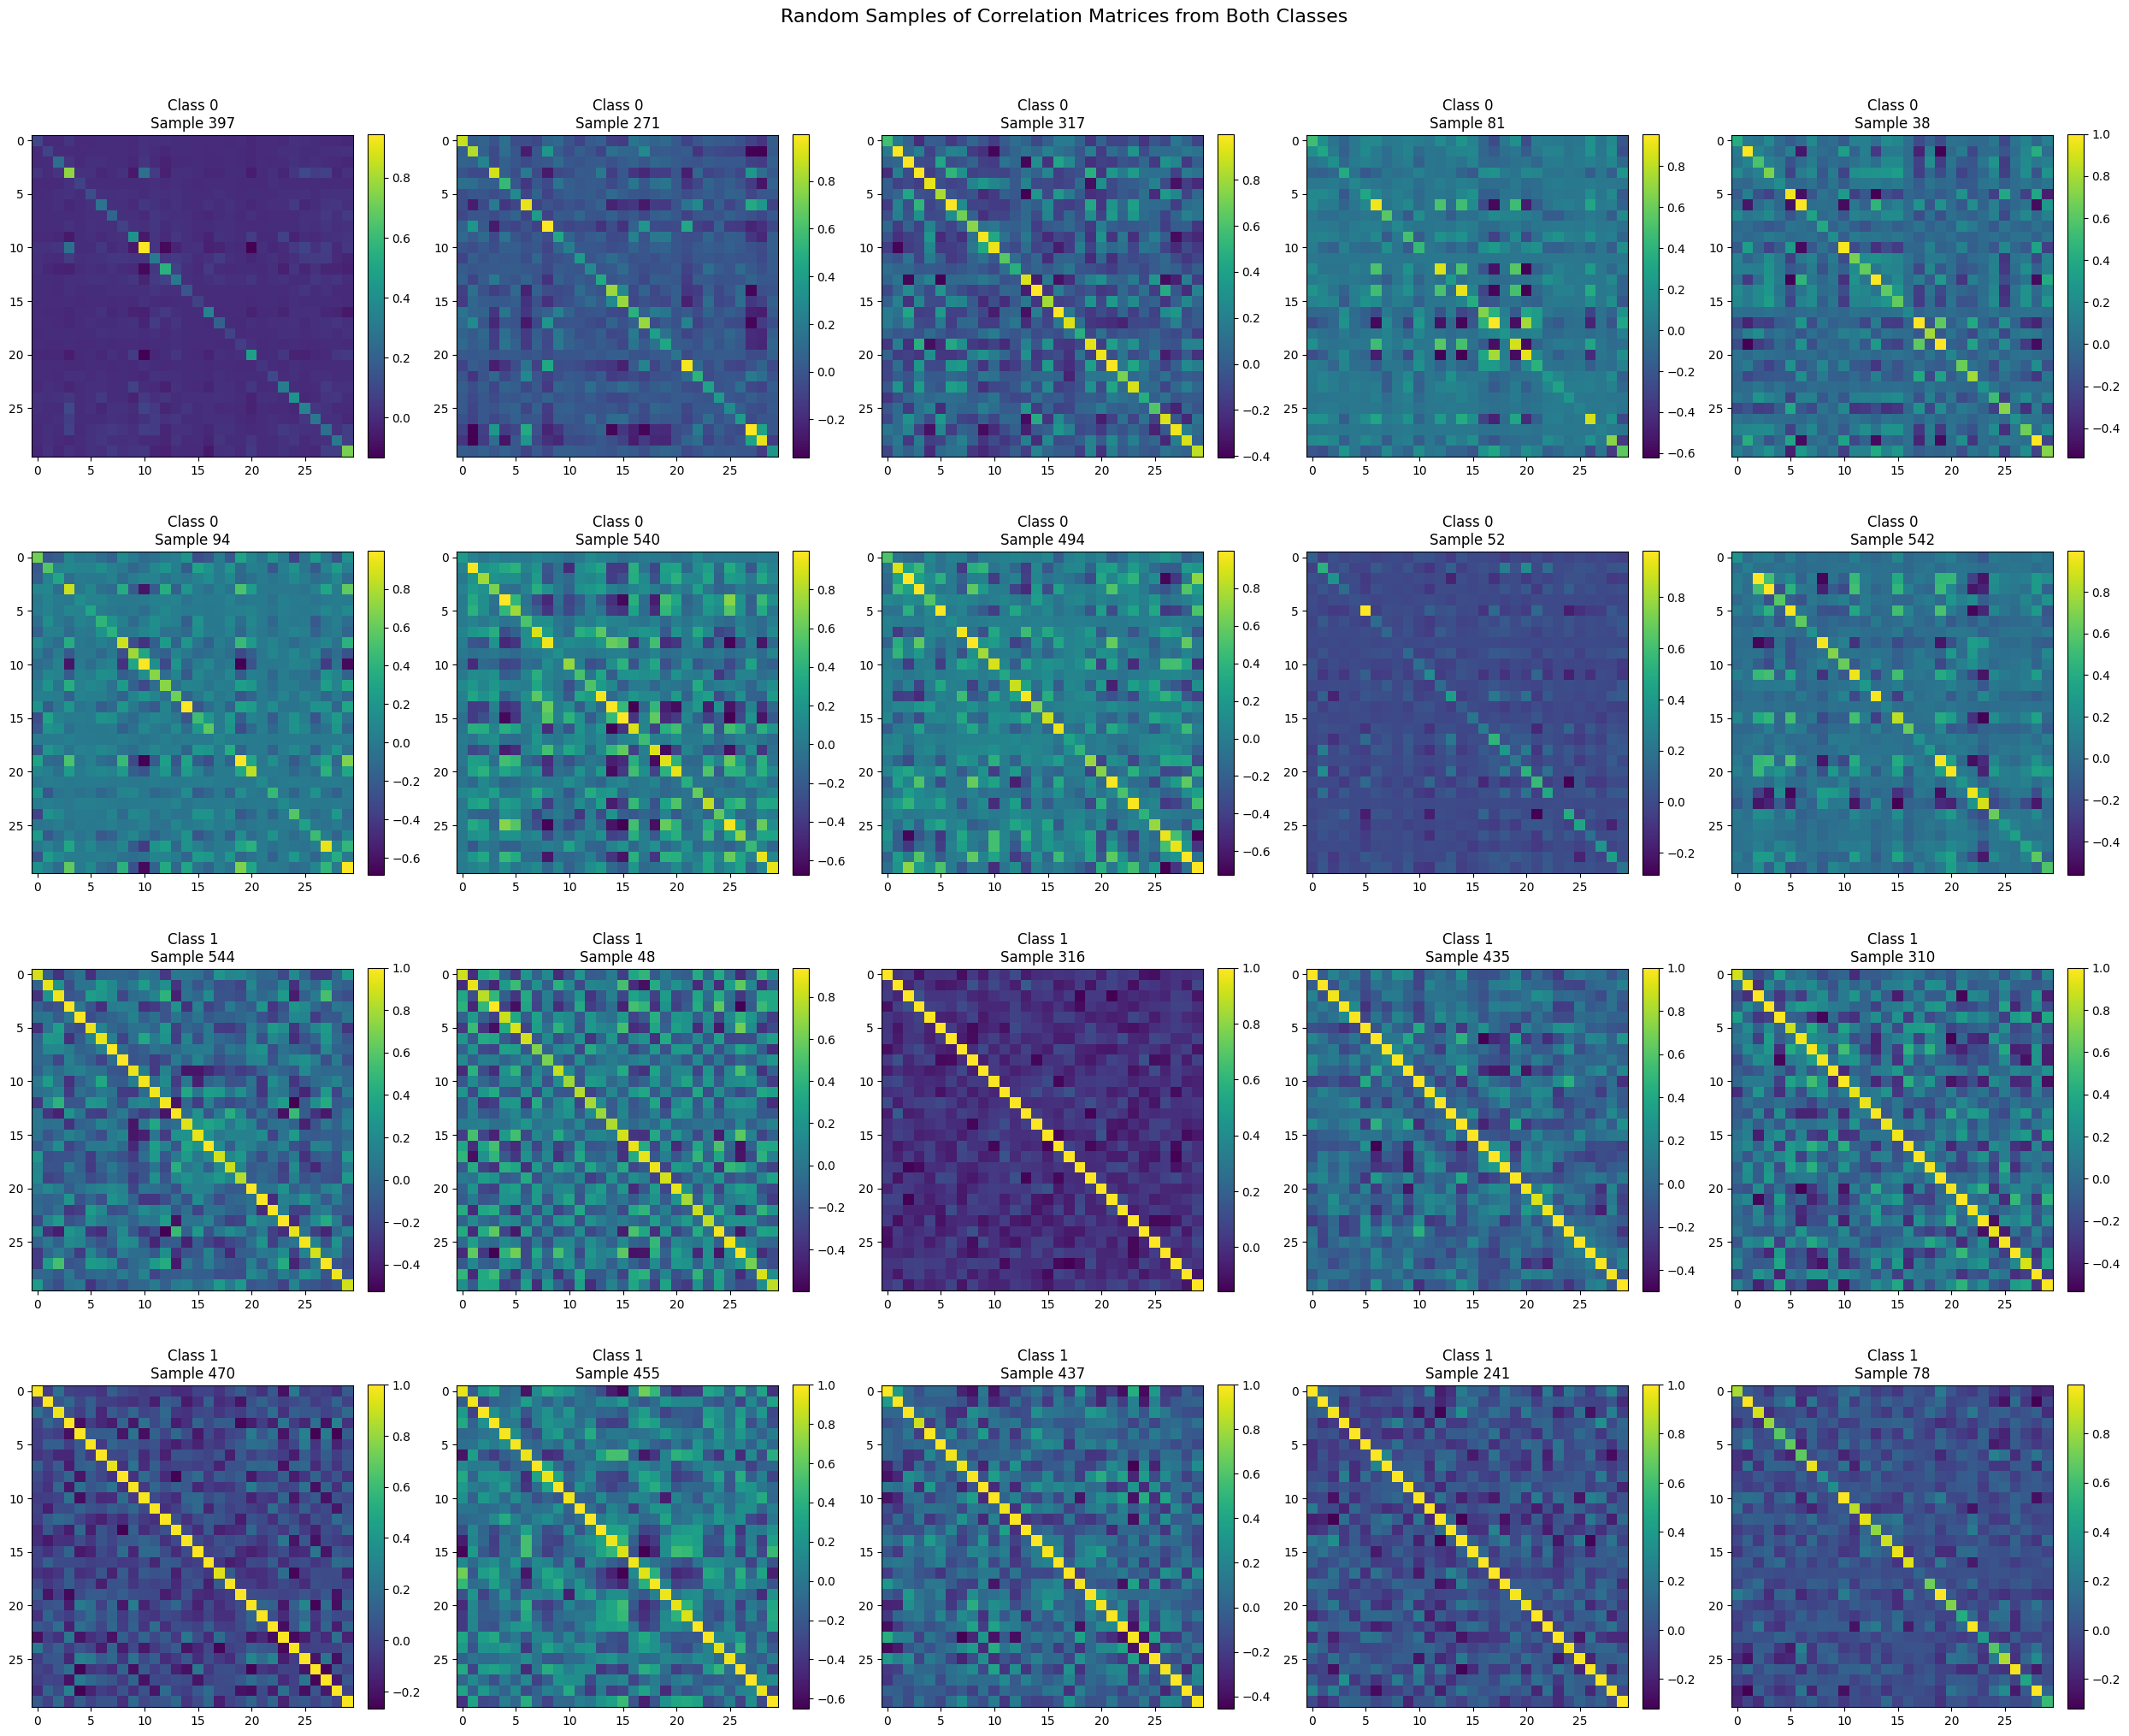

In [6]:
# Inspect the matrices
plt.figure(figsize=(25, 20))

# Plot 10 random matrices from class 0 
for i in range(10):
    row = i // 5  # 0 for first 5 items, 1 for next 5
    col = i % 5   # 0-4 for each row
    plt.subplot(4, 5, row*5 + col + 1)
    random_idx = np.random.randint(0, len(class_0_C))
    im = plt.imshow(class_0_C[random_idx], cmap='viridis')
    plt.title(f'Class 0\nSample {random_idx}')
    plt.colorbar(im, fraction=0.046, pad=0.04)

# Plot 10 random matrices from class 1 
for i in range(10):
    row = i // 5  # 0 for first 5 items, 1 for next 5
    col = i % 5   # 0-4 for each row
    plt.subplot(4, 5, (row+2)*5 + col + 1)  # +2 to start from third row
    random_idx = np.random.randint(0, len(class_1_C))
    im = plt.imshow(class_1_C[random_idx], cmap='viridis')
    plt.title(f'Class 1\nSample {random_idx}')
    plt.colorbar(im, fraction=0.046, pad=0.04)

# Add a main title
plt.suptitle('Random Samples of Correlation Matrices from Both Classes', 
             fontsize=16, y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/var/folders/rz/xbbk13895bx876fqwb2x4v540000gn/T/ipykernel_93714/2722434636.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mins, maxs], labels=['Min Values', 'Max Values'])
/var/folders/rz/xbbk13895bx876fqwb2x4v540000gn/T/ipykernel_93714/2722434636.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([class_mins, class_maxs], labels=['Min Values', 'Max Values'])
/var/folders/rz/xbbk13895bx876fqwb2x4v540000gn/T/ipykernel_93714/2722434636.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([class_mins, class_maxs], labels=['Min Values', 'Max Values'])


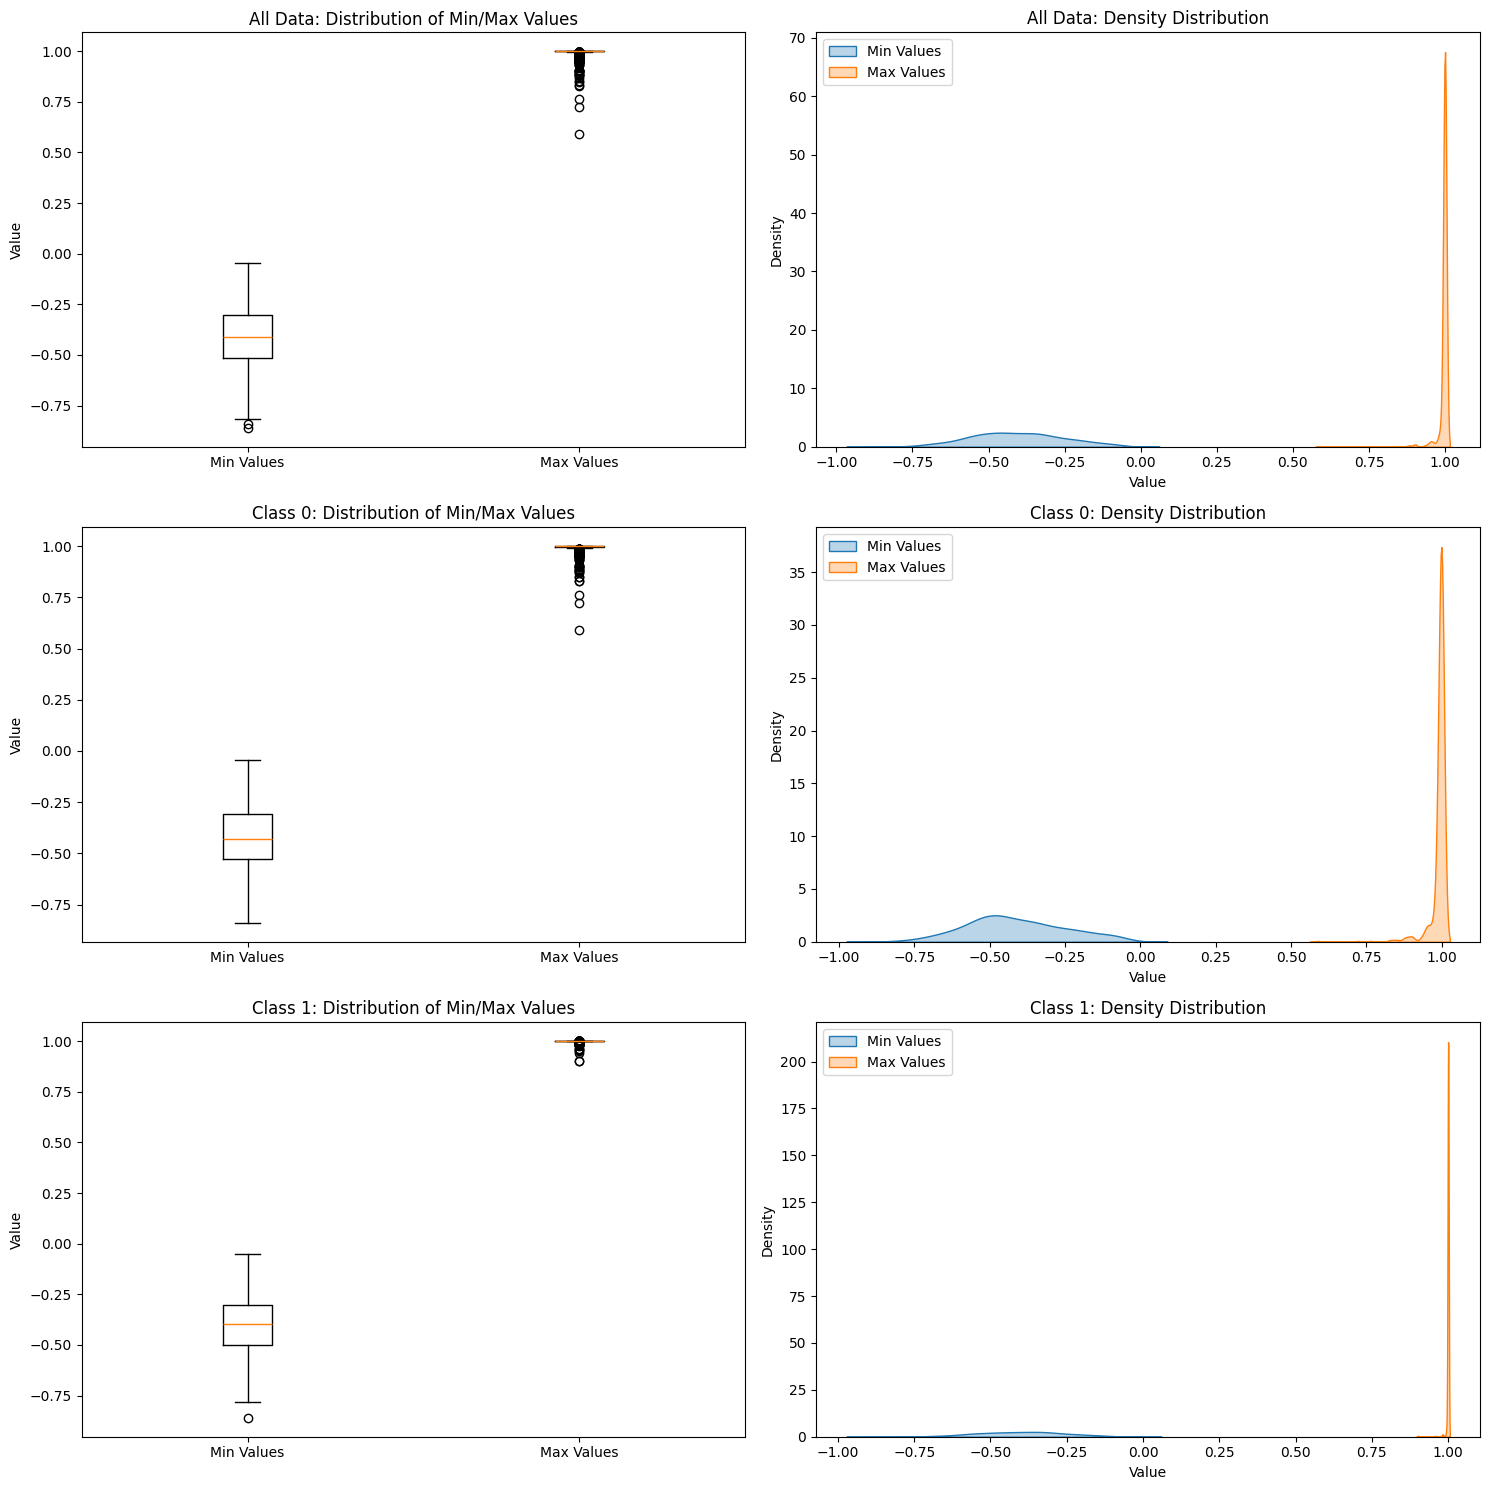

Overall Statistics:

Minimum values:
Mean: -0.4056, Std: 0.1502
Range: [-0.8604, -0.0451]

Maximum values:
Mean: 0.9952, Std: 0.0219
Range: [0.5892, 1.0001]

Class 0 Statistics:
Number of samples: 574

Minimum values:
Mean: -0.4131, Std: 0.1615
Range: [-0.8393, -0.0451]

Maximum values:
Mean: 0.9902, Std: 0.0318
Range: [0.5892, 1.0001]

Class 1 Statistics:
Number of samples: 755

Minimum values:
Mean: -0.3999, Std: 0.1407
Range: [-0.8604, -0.0514]

Maximum values:
Mean: 0.9990, Std: 0.0066
Range: [0.9004, 1.0001]


In [7]:
# Calculate min and max for each matrix
mins = np.array([matrix.min() for matrix in all_C])
maxs = np.array([matrix.max() for matrix in all_C])

plt.figure(figsize=(15, 15))

# Plot of all data
plt.subplot(321)
plt.boxplot([mins, maxs], labels=['Min Values', 'Max Values'])
plt.title('All Data: Distribution of Min/Max Values')
plt.ylabel('Value')

plt.subplot(322)
sns.kdeplot(data=mins, label='Min Values', fill=True, alpha=0.3)
sns.kdeplot(data=maxs, label='Max Values', fill=True, alpha=0.3)
plt.title('All Data: Density Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plots for each class
for idx, class_label in enumerate([0, 1]):
    class_indices = np.where(nMF_label == class_label)[0]
    class_mins = mins[class_indices]
    class_maxs = maxs[class_indices]
    
    # Box plot for class
    plt.subplot(323 + idx*2)
    plt.boxplot([class_mins, class_maxs], labels=['Min Values', 'Max Values'])
    plt.title(f'Class {class_label}: Distribution of Min/Max Values')
    plt.ylabel('Value')
    
    # Density plot for class
    plt.subplot(324 + idx*2)
    sns.kdeplot(data=class_mins, label='Min Values', fill=True, alpha=0.3)
    sns.kdeplot(data=class_maxs, label='Max Values', fill=True, alpha=0.3)
    plt.title(f'Class {class_label}: Density Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

# Print statistics for all data and by class
print("Overall Statistics:")
print("\nMinimum values:")
print(f"Mean: {np.mean(mins):.4f}, Std: {np.std(mins):.4f}")
print(f"Range: [{np.min(mins):.4f}, {np.max(mins):.4f}]")

print("\nMaximum values:")
print(f"Mean: {np.mean(maxs):.4f}, Std: {np.std(maxs):.4f}")
print(f"Range: [{np.min(maxs):.4f}, {np.max(maxs):.4f}]")

# Print statistics by class
for class_label in [0, 1]:
    class_indices = np.where(nMF_label == class_label)[0]
    class_mins = mins[class_indices]
    class_maxs = maxs[class_indices]
    
    print(f"\nClass {class_label} Statistics:")
    print(f"Number of samples: {len(class_indices)}")
    print("\nMinimum values:")
    print(f"Mean: {np.mean(class_mins):.4f}, Std: {np.std(class_mins):.4f}")
    print(f"Range: [{np.min(class_mins):.4f}, {np.max(class_mins):.4f}]")
    
    print("\nMaximum values:")
    print(f"Mean: {np.mean(class_maxs):.4f}, Std: {np.std(class_maxs):.4f}")
    print(f"Range: [{np.min(class_maxs):.4f}, {np.max(class_maxs):.4f}]")

# Training the Model

In [ ]:
# Load environment variables from .env file
load_dotenv()

# Get my API key from environment variable first
wandb_key = os.getenv('WANDB_API_KEY')

# If not found in environment, prompt user
if not wandb_key:
    wandb_key = getpass("Enter your Weights & Biases API key: ")

wandb.login(key=wandb_key)
# Hyperparameter grid
param_grid = {
    'learning_rate': [1e-3, 1e-4],
    'conv_channels': [[1, 16, 32, 64], [1, 32, 64, 128]],
    'dropout_rate': [0.3, 0.5],
}

# K-fold setup
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid search with k-fold cross validation
best_val_acc = 0
best_params = None

print("Starting grid search with k-fold cross validation")
print(f"Parameter grid:\n{param_grid}")
print(f"Number of folds: {kfold.n_splits}\n")

for lr in param_grid['learning_rate']:
    for conv_ch in param_grid['conv_channels']:
        for dropout in param_grid['dropout_rate']:

            print("\n" + "="*80)
            print(f"Training with parameters:")
            print(f"Learning rate: {lr}")
            print(f"Conv channels: {conv_ch}")
            print(f"Dropout rate: {dropout}\n")

            fold_scores = []
            
            # Initialize a new wandb run
            run = wandb.init(
                project="inverse_problem",
                config={
                    "learning_rate": lr,
                    "conv_channels": conv_ch,
                    "dropout_rate": dropout,
                }
            )
            
            for fold, (train_idx, val_idx) in enumerate(kfold.split(all_C)):
                print(f"\nFold {fold+1}/{kfold.n_splits}")
                print(f"Train size: {len(train_idx)}, Validation size: {len(val_idx)}")
                
                # Prepare data
                train_dataset = MatrixDataset(all_C[train_idx], nMF_label[train_idx])
                val_dataset = MatrixDataset(all_C[val_idx], nMF_label[val_idx])
                
                train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=32)
                
                # Initialize model and trainer
                model = CNNClassifier(
                    learning_rate=lr,
                    conv_channels=conv_ch,
                    dropout_rate=dropout
                )
                
                checkpoint_callback = ModelCheckpoint(
                    monitor='val_acc',
                    dirpath='checkpoints',
                    filename=f'fold_{fold}',
                    save_top_k=1,
                    mode='max'
                )
                
                trainer = pl.Trainer(
                    max_epochs=50,
                    logger=WandbLogger(project="inverse_problem"),
                    callbacks=[checkpoint_callback],
                    accelerator='auto'
                )

                # Train model
                print("Training model...")
                trainer.fit(model, train_loader, val_loader)
                
                fold_score = checkpoint_callback.best_model_score.item()
                fold_scores.append(fold_score)
                print(f"Fold {fold+1} best validation accuracy: {fold_score:.4f}")
            
            # Calculate average score for this parameter combination
            avg_score = np.mean(fold_scores)
            print("\nResults for current parameters:")
            print(f"Average validation accuracy: {avg_score:.4f}")
            print(f"Standard deviation: {np.std(fold_scores):.4f}")
            

            if avg_score > best_val_acc:
                best_val_acc = avg_score
                best_params = {
                    'learning_rate': lr,
                    'conv_channels': conv_ch,
                    'dropout_rate': dropout
                }
                print("\n🌟 New best model found!")
                print(f"Best validation accuracy so far: {best_val_acc:.4f}")
            
            wandb.finish()
            print("\nFinished wandb run")

print("\n" + "="*80)
print("Grid search completed!")
print("\nBest parameters found:")
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Conv channels: {best_params['conv_channels']}")
print(f"Dropout rate: {best_params['dropout_rate']}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

In [ ]:
# Feature map visualization
def visualize_feature_maps(feature_maps, sample_idx=0):
    plt.figure(figsize=(15, 5))
    for i, (name, features) in enumerate(feature_maps.items()):
        # Get the first sample's feature maps
        feature_map = features[sample_idx].cpu().numpy()
        
        # Create subplot for each conv layer
        n_features = min(4, feature_map.shape[0])  # Show up to 4 features
        for j in range(n_features):
            plt.subplot(len(feature_maps), 4, i*4 + j + 1)
            plt.imshow(feature_map[j], cmap='viridis')
            plt.axis('off')
            if j == 0:
                plt.title(f'{name}\nChannel {j}')
            else:
                plt.title(f'Channel {j}')
    
    plt.tight_layout()
    plt.show()

# Load best model and get feature maps
best_model = CNNClassifier.load_from_checkpoint('checkpoints/best_model.ckpt')
sample_input = torch.FloatTensor(all_C[:1]).unsqueeze(1)  # Get first sample
feature_maps = get_feature_maps(best_model, sample_input)
visualize_feature_maps(feature_maps)